In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import local_binary_pattern

In [3]:
DATA_PATH = "/content/drive/MyDrive/Final Project Computer Vision & Deep Learning/MPox-Vision"
IMG_SIZE = (224, 224)
NUM_CLUSTERS = 200
SEED = 42

In [4]:
classes = os.listdir(DATA_PATH)
print(classes)

['Monkeypox', 'Measles', 'Acne', 'Chickenpox']


# **Preprocessing**

In [5]:
def preprocess_image(image):
    img = cv2.resize(image, IMG_SIZE)

    # CLAHE untuk peningkatan kontras
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Denoising untuk mengurangi noise
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return gray, img

In [6]:
def extract_color_features(image):
    # RGB features
    (R, G, B) = cv2.split(image)

    # HSV features
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    (H, S, V) = cv2.split(hsv)

    features = [
        # Mean RGB
        np.mean(R)/255.0, np.mean(G)/255.0, np.mean(B)/255.0,
        # Std RGB
        np.std(R)/255.0, np.std(G)/255.0, np.std(B)/255.0,
        # Mean HSV
        np.mean(H)/180.0, np.mean(S)/255.0, np.mean(V)/255.0,
        # Std HSV
        np.std(H)/180.0, np.std(S)/255.0, np.std(V)/255.0,
        # Skewness dan Kurtosis untuk distribusi warna
        np.median(R)/255.0, np.median(G)/255.0, np.median(B)/255.0,
    ]

    return np.array(features)

# LBP

In [7]:
def extract_texture_features(gray_image):
    # Local Binary Pattern (LBP)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')

    # Histogram LBP
    n_bins = n_points + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    return hist

# SIFT

In [ ]:
def extract_sift_features(gray_image, kmeans):
    sift = cv2.SIFT_create(nfeatures=500)  # Batasi jumlah keypoints
    kp, des = sift.detectAndCompute(gray_image, None)

    if des is not None and len(des) > 0:
        words = kmeans.predict(des)
        hist, _ = np.histogram(words, bins=np.arange(NUM_CLUSTERS + 1))
        hist = hist.astype(np.float32)
        # L2 normalization
        hist = hist / (np.linalg.norm(hist) + 1e-7)
    else:
        hist = np.zeros(NUM_CLUSTERS, dtype=np.float32)

    return hist

In [9]:
def data_augmentation(image):
    augmented = []

    # Original
    augmented.append(image)

    # Horizontal flip
    augmented.append(cv2.flip(image, 1))

    # Rotation
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    for angle in [-15, 15]:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        augmented.append(rotated)

    # Brightness adjustment
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = hsv.astype(np.float32)
    hsv[:, :, 2] = hsv[:, :, 2] * 1.2  # Increase brightness
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
    hsv = hsv.astype(np.uint8)
    bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    augmented.append(bright)

    return augmented

In [10]:
print("Collecting SIFT descriptors...\n")

sift = cv2.SIFT_create(nfeatures=500)
all_descriptors = []
image_data = []

for idx, cls in enumerate(classes):
    folder = os.path.join(DATA_PATH, cls)
    if not os.path.isdir(folder):
        continue

    print(f"Processing {cls} data...")
    for f in os.listdir(folder):
        img_path = os.path.join(folder, f)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Data augmentation
        augmented_images = data_augmentation(img)

        for aug_id, aug_img in enumerate(augmented_images):
            gray, _ = preprocess_image(aug_img)
            kp, des = sift.detectAndCompute(gray, None)

            if des is not None:
                all_descriptors.append(des)
                image_data.append((img_path, idx, aug_id))

all_descriptors_vstack = np.vstack(all_descriptors)
print(f"Total descriptors: {all_descriptors_vstack.shape}")


Processing Monkeypox data...
Processing Measles data...
Processing Acne data...
Processing Chickenpox data...
Total descriptors: (847937, 128)


In [11]:
print("Creating visual vocabulary...\n")

kmeans = MiniBatchKMeans(
    n_clusters=NUM_CLUSTERS,
    random_state=SEED,
    batch_size=2000,
    n_init=10,
    max_iter=300
)
kmeans.fit(all_descriptors_vstack)
print("Visual vocabulary created")

Creating visual vocabulary...

Visual vocabulary created


# Feature Extractions

In [12]:
print("Extracting features...\n")

X_features = []
y_labels = []

for img_path, label, aug_id in image_data:
    img = cv2.imread(img_path)

    # Apply augmentation
    augmented_images = data_augmentation(img)
    aug_img = augmented_images[aug_id]

    gray, img_color = preprocess_image(aug_img)

    # SIFT BoVW features
    sift_hist = extract_sift_features(gray, kmeans)

    # Color features
    color_feats = extract_color_features(img_color)

    # Texture features (LBP)
    texture_feats = extract_texture_features(gray)

    # Concat all features
    final_vector = np.concatenate([sift_hist, color_feats, texture_feats])

    X_features.append(final_vector)
    y_labels.append(label)

X = np.array(X_features)
y = np.array(y_labels)

print(f"Feature dimension: {X.shape}")
print(f"Total samples: {len(y)}")

Extracting features...

Feature dimension: (3999, 241)
Total samples: 3999


# Train Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training

In [14]:
print("Training Model with Grid Search\n")

# Grid search untuk hyperparameter tuning
param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

svm_model = SVC(probability=True, random_state=SEED)
grid_search = GridSearchCV(
    svm_model,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_*100:.2f}%")

best_model = grid_search.best_estimator_

Training Model with Grid Search

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 89.00%


# Model Evaluation

In [15]:
y_pred = best_model.predict(X_test_scaled)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=classes))

print(f"\nTest accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")


Classification report:
              precision    recall  f1-score   support

   Monkeypox       0.96      0.91      0.93       200
     Measles       0.93      0.96      0.94       200
        Acne       0.91      0.89      0.90       200
  Chickenpox       0.86      0.90      0.88       200

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800


Test accuracy: 91.25%


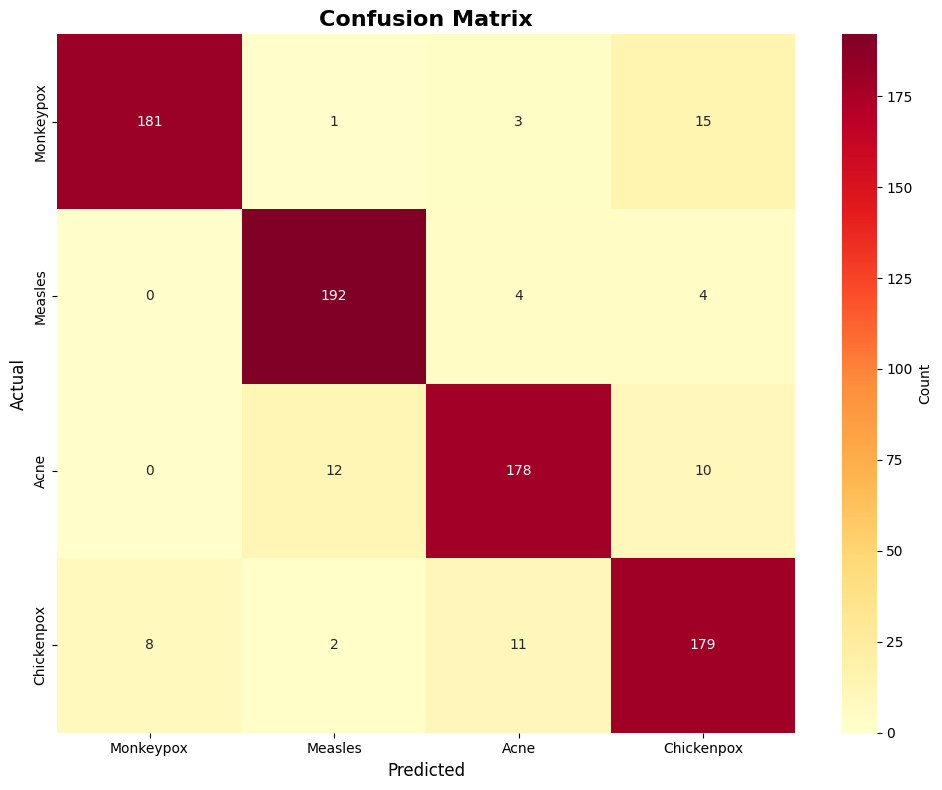

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlOrRd", xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.tight_layout()
plt.show()

# Save Model

In [21]:
print("Saving model...\n")

model_bundle = {
    'kmeans': kmeans,
    'scaler': scaler,
    'model': best_model,
    'classes': classes,
    'num_clusters': NUM_CLUSTERS
}

joblib.dump(model_bundle, '/content/drive/MyDrive/Final Project Computer Vision & Deep Learning/monkeypox_model_final.pkl')
print('Model saved successfully')

Saving model...

Model saved successfully
